# Electric Consumption and Cost

Data is retrieved from [NYC Open Data](https://data.cityofnewyork.us/Housing-Development/Electric-Consumption-And-Cost-2010-April-2020-/jr24-e7cr).

This project is divided into the following:
* Data Preparation
* Testing & Training
* PCA
* k-means
* Aggolmerate/Hierarchical
* DBSCAN

# Data Preparation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pandas.plotting import scatter_matrix
import mglearn

import warnings
warnings.filterwarnings('ignore')

In [3]:
ec = pd.read_csv("/Users/sheryl/GitHub/data71200su21/Project 1/dataset/electric-consumption.csv",  
                                   low_memory=False)

In [4]:
ec

,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,...,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,15396.82,GOV/NYC/068,Yes,128800,7387.97,216.00,2808.00,5200.85
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14556.34,GOV/NYC/068,Yes,115200,6607.87,224.00,2912.00,5036.47
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13904.98,GOV/NYC/068,Yes,103200,5919.55,216.00,2808.00,5177.43
3,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14764.04,GOV/NYC/068,Yes,105600,6057.22,208.00,2704.00,6002.82
4,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13729.54,GOV/NYC/068,Yes,97600,5598.34,216.00,2808.00,5323.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301312,WYCKOFF GARDENS,BROOKLYN,WYCKOFF GARDENS,BLD 02,INTERVAL,NaN,163.0,272,K016300,FEDERAL,...,1096666,N,1287.71,GOV/NYC/068,Yes,0,0.00,116.16,1160.44,127.27
301313,WYCKOFF GARDENS,BROOKLYN,WYCKOFF GARDENS,BLD 03,INTERVAL,NaN,163.0,272,K016300,FEDERAL,...,1096667,N,1705.42,GOV/NYC/068,Yes,0,0.00,153.84,1536.86,168.56
301314,WYCKOFF GARDENS,BROOKLYN,WYCKOFF GARDENS,BLD 03,AMR,NaN,163.0,272,K016300,FEDERAL,...,8096664,N,3782.25,GOV/NYC/068,Yes,101200,3408.42,0.00,0.00,373.83
301315,WYCKOFF GARDENS,BROOKLYN,WYCKOFF GARDENS,BLD 02,AMR,NaN,163.0,272,K016300,FEDERAL,...,8096666,N,2541.43,GOV/NYC/068,Yes,68000,2290.24,0.00,0.00,251.19


In [5]:
ec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301317 entries, 0 to 301316
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Development Name    301193 non-null  object 
 1   Borough             301317 non-null  object 
 2   Account Name        301317 non-null  object 
 3   Location            293386 non-null  object 
 4   Meter AMR           301231 non-null  object 
 5   Meter Scope         15799 non-null   object 
 6   TDS #               299936 non-null  float64
 7   EDP                 301317 non-null  int64  
 8   RC Code             301317 non-null  object 
 9   Funding Source      301317 non-null  object 
 10  AMP #               299972 non-null  object 
 11  Vendor Name         301317 non-null  object 
 12  UMIS BILL ID        301317 non-null  int64  
 13  Revenue Month       301317 non-null  object 
 14  Service Start Date  301314 non-null  object 
 15  Service End Date    301314 non-nul

In [6]:
ec.hist

<bound method hist_frame of        Development Name   Borough     Account Name Location Meter AMR  \
0                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
1                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
2                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
3                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
4                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
...                 ...       ...              ...      ...       ...   
301312  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 02  INTERVAL   
301313  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 03  INTERVAL   
301314  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 03       AMR   
301315  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 02       AMR   
301316  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 03       AMR   

         Meter Scope  TDS #  EDP  RC Code Funding Source  ... Meter Number  \
0       BLD 01 to

In [7]:
ec_drop0 = ec[ec != 0]
print(ec_drop0)

       Development Name   Borough     Account Name Location Meter AMR  \
0                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
1                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
2                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
3                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
4                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
...                 ...       ...              ...      ...       ...   
301312  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 02  INTERVAL   
301313  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 03  INTERVAL   
301314  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 03       AMR   
301315  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 02       AMR   
301316  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 03       AMR   

         Meter Scope  TDS #  EDP  RC Code Funding Source  ... Meter Number  \
0       BLD 01 to 07  118.0  248  B011800    

In [8]:
ec_negative = ec_drop0[ec_drop0['Current Charges'] > 0]
print(ec_negative)

       Development Name   Borough     Account Name Location Meter AMR  \
0                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
1                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
2                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
3                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
4                 ADAMS     BRONX            ADAMS   BLD 05      NONE   
...                 ...       ...              ...      ...       ...   
301312  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 02  INTERVAL   
301313  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 03  INTERVAL   
301314  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 03       AMR   
301315  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 02       AMR   
301316  WYCKOFF GARDENS  BROOKLYN  WYCKOFF GARDENS   BLD 03       AMR   

         Meter Scope  TDS #  EDP  RC Code Funding Source  ... Meter Number  \
0       BLD 01 to 07  118.0  248  B011800    

In [9]:
ec_dropcolumns = ec_negative.drop(["UMIS BILL ID", "Consumption (KW)", "KW Charges", "Other charges", 
                               "Bill Analyzed", "Meter Number", "AMP #", "Account Name", "Service Start Date",
                              "Service End Date", "RC Code", "Development Name", "Location", "Meter AMR", "Meter Scope",
                              "Vendor Name", "Funding Source", "Rate Class", "Revenue Month", "Estimated"], axis=1)
print(ec_dropcolumns)

         Borough  TDS #  EDP  # days  Current Charges  Consumption (KWH)  \
0          BRONX  118.0  248    33.0         15396.82           128800.0   
1          BRONX  118.0  248    30.0         14556.34           115200.0   
2          BRONX  118.0  248    29.0         13904.98           103200.0   
3          BRONX  118.0  248    31.0         14764.04           105600.0   
4          BRONX  118.0  248    28.0         13729.54            97600.0   
...          ...    ...  ...     ...              ...                ...   
301312  BROOKLYN  163.0  272    29.0          1287.71                NaN   
301313  BROOKLYN  163.0  272    29.0          1705.42                NaN   
301314  BROOKLYN  163.0  272    29.0          3782.25           101200.0   
301315  BROOKLYN  163.0  272    29.0          2541.43            68000.0   
301316  BROOKLYN  163.0  272    29.0          2967.49            79400.0   

        KWH Charges  
0           7387.97  
1           6607.87  
2           5919.55  

In [10]:
ec_new = ec_dropcolumns.dropna()
print(ec_new)

         Borough  TDS #  EDP  # days  Current Charges  Consumption (KWH)  \
0          BRONX  118.0  248    33.0         15396.82           128800.0   
1          BRONX  118.0  248    30.0         14556.34           115200.0   
2          BRONX  118.0  248    29.0         13904.98           103200.0   
3          BRONX  118.0  248    31.0         14764.04           105600.0   
4          BRONX  118.0  248    28.0         13729.54            97600.0   
...          ...    ...  ...     ...              ...                ...   
301309  BROOKLYN  163.0  272    29.0          5608.58            67600.0   
301310  BROOKLYN  163.0  272    29.0          6438.24            77600.0   
301314  BROOKLYN  163.0  272    29.0          3782.25           101200.0   
301315  BROOKLYN  163.0  272    29.0          2541.43            68000.0   
301316  BROOKLYN  163.0  272    29.0          2967.49            79400.0   

        KWH Charges  
0           7387.97  
1           6607.87  
2           5919.55  

In [11]:
#replace boroughs with numerical numbers
#ec_final = ec_freq.replace({'BROOKLYN': 1, 'MANHATTAN': 4, 'BRONX': 2, 'QUEENS': 5, 'STATEN ISLAND': 6, 'FHA': 3})
#print(ec_final)

In [12]:
# Brooklyn - 1
# Bronx - 2
# FHA - 3
# Manhattan - 4
# Queens - 5
# Staten Island - 6

#ec_final['Borough'].value_counts()

In [13]:
#ec_final.info()

In [14]:
#ec_final.describe()

In [15]:
#drop the frequencies of Consumption values less than 10
counts = ec_new['Consumption (KWH)'].value_counts()
ec_final = ec_new[~ec_new['Consumption (KWH)'].isin(counts[counts < 10].index)]
print(ec_final)

         Borough  TDS #  EDP  # days  Current Charges  Consumption (KWH)  \
0          BRONX  118.0  248    33.0         15396.82           128800.0   
1          BRONX  118.0  248    30.0         14556.34           115200.0   
2          BRONX  118.0  248    29.0         13904.98           103200.0   
3          BRONX  118.0  248    31.0         14764.04           105600.0   
4          BRONX  118.0  248    28.0         13729.54            97600.0   
...          ...    ...  ...     ...              ...                ...   
301309  BROOKLYN  163.0  272    29.0          5608.58            67600.0   
301310  BROOKLYN  163.0  272    29.0          6438.24            77600.0   
301314  BROOKLYN  163.0  272    29.0          3782.25           101200.0   
301315  BROOKLYN  163.0  272    29.0          2541.43            68000.0   
301316  BROOKLYN  163.0  272    29.0          2967.49            79400.0   

        KWH Charges  
0           7387.97  
1           6607.87  
2           5919.55  

In [16]:
#Dropping the outlier rows with standard deviation
factor = 100000
upper_lim = ec_final['Consumption (KWH)'].mean () + ec_final["Consumption (KWH)"].std () * factor
lower_lim = ec_final["Consumption (KWH)"].mean () - ec_final["Consumption (KWH)"].std () * factor

ec_final = ec_final[(ec_final["Consumption (KWH)"] < upper_lim) & (ec_final["Consumption (KWH)"] > lower_lim)]

In [17]:
encoded_columns = pd.get_dummies(ec_final['Borough'])
ec_final = ec_final.join(encoded_columns).drop('Borough', axis=1)

In [18]:
ec_corr_matrix = ec_final.corr()
ec_corr_matrix['Consumption (KWH)'].sort_values(ascending=False)

Consumption (KWH)    1.000000
KWH Charges          0.960410
Current Charges      0.935115
STATEN ISLAND        0.129028
MANHATTAN            0.103514
BRONX                0.061376
# days               0.035249
QUEENS              -0.063045
FHA                 -0.063104
BROOKLYN            -0.119851
EDP                 -0.263228
TDS #               -0.283315
Name: Consumption (KWH), dtype: float64

In [19]:
ec_final.describe()

,TDS #,EDP,# days,Current Charges,Consumption (KWH),KWH Charges,BRONX,BROOKLYN,FHA,MANHATTAN,QUEENS,STATEN ISLAND
count,191832.000000,191832.000000,191832.000000,191832.000000,191832.000000,191832.000000,191832.000000,191832.000000,191832.000000,191832.000000,191832.000000,191832.000000
mean,139.873040,434.805564,30.359877,5403.773708,44229.928886,2145.255926,0.231494,0.401836,0.003446,0.255380,0.101245,0.006600
std,135.844479,185.868879,1.644027,5206.873244,41029.105579,2082.219438,0.421789,0.490270,0.058599,0.436076,0.301653,0.080969
min,1.000000,200.000000,1.000000,0.310000,1.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,237.000000,29.000000,1668.205000,15480.000000,709.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,74.000000,429.000000,30.000000,4146.890000,35280.000000,1672.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,240.000000,566.000000,31.000000,7402.150000,61200.000000,2926.590000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,582.000000,871.000000,152.000000,81084.020000,345600.000000,38313.270000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Training Set, Test Set, & Target Attribute

In [20]:
#data = pd.DataFrame({'value':[2,45, -23, 85, 28, 2, 35, -12]})
ec_final['log+1'] = (ec_final['Consumption (KWH)']+1).transform(np.log)
#Negative Values Handling
#Note that the values are different
ec_final['log'] = (ec_final['Consumption (KWH)']-ec_final['Consumption (KWH)'].min()+1) .transform(np.log)

In [21]:
X = ec_final.drop(["TDS #", "EDP", "# days", "BRONX",  "BROOKLYN",  "FHA",  "MANHATTAN",  "QUEENS", "STATEN ISLAND"],axis=1)
print(X)

        Current Charges  Consumption (KWH)  KWH Charges      log+1        log
0              15396.82           128800.0      7387.97  11.766024  11.766016
1              14556.34           115200.0      6607.87  11.654434  11.654425
2              13904.98           103200.0      5919.55  11.544434  11.544424
3              14764.04           105600.0      6057.22  11.567423  11.567414
4              13729.54            97600.0      5598.34  11.488643  11.488633
...                 ...                ...          ...        ...        ...
301309          5608.58            67600.0      2276.77  11.121378  11.121363
301310          6438.24            77600.0      2613.57  11.259336  11.259323
301314          3782.25           101200.0      3408.42  11.524864  11.524854
301315          2541.43            68000.0      2290.24  11.127278  11.127263
301316          2967.49            79400.0      2674.19  11.282266  11.282254

[191832 rows x 5 columns]


In [22]:
y = ec_final[["BRONX",  "BROOKLYN",  "FHA",  "MANHATTAN",  "QUEENS", "STATEN ISLAND"]]
print(y)

        BRONX  BROOKLYN  FHA  MANHATTAN  QUEENS  STATEN ISLAND
0           1         0    0          0       0              0
1           1         0    0          0       0              0
2           1         0    0          0       0              0
3           1         0    0          0       0              0
4           1         0    0          0       0              0
...       ...       ...  ...        ...     ...            ...
301309      0         1    0          0       0              0
301310      0         1    0          0       0              0
301314      0         1    0          0       0              0
301315      0         1    0          0       0              0
301316      0         1    0          0       0              0

[191832 rows x 6 columns]


In [61]:
y1_column = ec_new.replace({'BROOKLYN': 1, 'MANHATTAN': 4, 'BRONX': 2, 'QUEENS': 5, 'STATEN ISLAND': 6, 'FHA': 3})
y1 = y1_column['Borough']

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [24]:
print("Shape of original Electric Consumption dataset :", ec_final.shape)
print("Shape of X training set :", X_train.shape)
print("Shape of y training set :", y_train.shape)
print("Shape of X testing set :", X_test.shape)
print("Shape of y testing set :", y_test.shape)

Shape of original Electric Consumption dataset : (191832, 14)
Shape of X training set : (95916, 5)
Shape of y training set : (95916, 6)
Shape of X testing set : (95916, 5)
Shape of y testing set : (95916, 6)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5f138e1d0>,
      dtype=object)

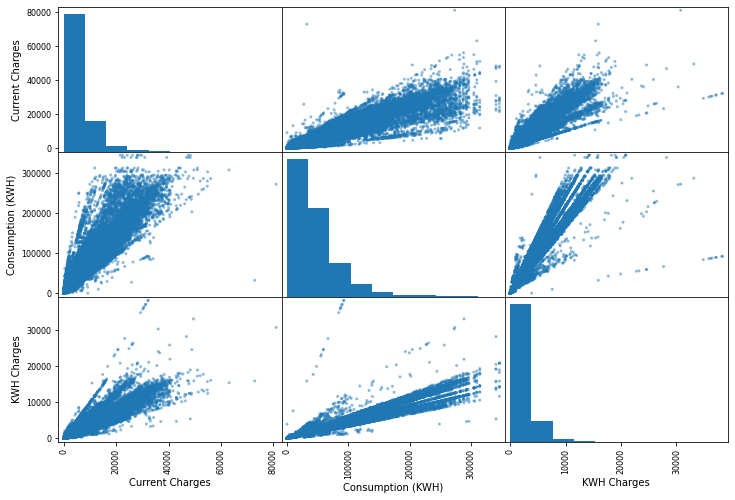

In [25]:
attributes = ["Current Charges", "Consumption (KWH)", "KWH Charges"]
scatter_matrix(ec_final[attributes], figsize=(12, 8))

In [26]:
ec_final.sample(10)

,TDS #,EDP,# days,Current Charges,Consumption (KWH),KWH Charges,BRONX,BROOKLYN,FHA,MANHATTAN,QUEENS,STATEN ISLAND,log+1,log
175266,67.0,222,30.0,3048.45,22880.0,1182.21,1,0,0,0,0,0,10.038062,10.038018
299313,63.0,218,29.0,568.52,28200.0,952.27,1,0,0,0,0,0,10.247113,10.247077
134173,36.0,314,29.0,4145.49,24320.0,1256.61,0,1,0,0,0,0,10.099095,10.099054
196718,44.0,584,29.0,8872.24,95840.0,3391.14,0,1,0,0,0,0,11.470446,11.470435
175665,67.0,222,30.0,3719.41,41120.0,1909.81,1,0,0,0,0,0,10.624274,10.624250
147800,61.0,216,30.0,7356.98,52400.0,2707.51,0,1,0,0,0,0,10.866681,10.866662
249838,48.0,369,31.0,2472.74,22160.0,911.27,0,0,0,0,1,0,10.006089,10.006044
198146,40.0,579,29.0,5380.77,50720.0,1816.79,1,0,0,0,0,0,10.834095,10.834076
231366,80.0,431,32.0,11026.77,84400.0,3457.87,1,0,0,0,0,0,11.343335,11.343323
149098,302.0,565,30.0,244.74,954.0,62.74,0,1,0,0,0,0,6.861711,6.860664


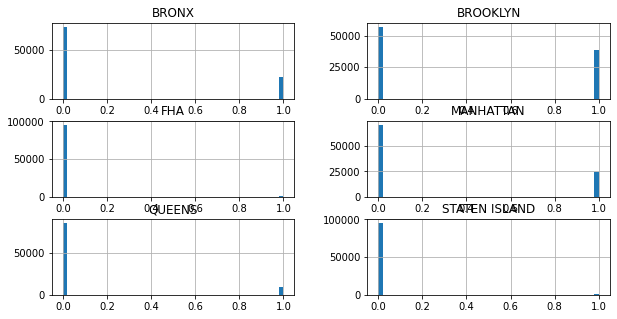

In [31]:
y_train.hist(bins=50, figsize=(10,5)) 
plt.show()